In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import zutils

# Implementing Memory Pro

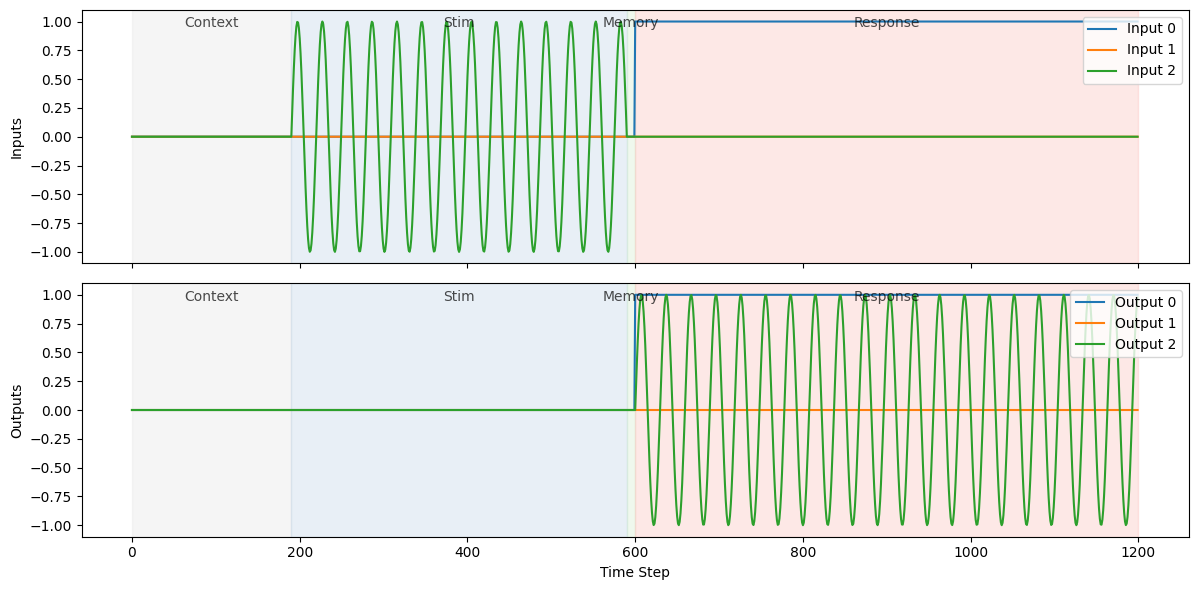

In [2]:
"""
Generate inputs and outputs for SNN training.
"""

context = zutils.TrialContext(
    num_trials=256,
    trial_length=1200,
    stim_length=400,
    memory_length=10,
    response_length=600,
    num_rules=3,
    rule=0,
    freq_min=10.0,
    freq_max=50.0,
    time_step=1e-3,
    device='cpu',
    dtype=torch.float
)

inputs = zutils.generate_snn_inputs(context)
outputs = zutils.generate_snn_outputs(context)
zutils.plot_trial(inputs, outputs, context, trial_idx=0)

In [3]:
# Network parameters
nb_inputs  = 6
nb_hidden  = 100
nb_outputs = 3
time_step = 1e-3

# Training parameters
nb_steps  = 1199
batch_size = 256
dtype = torch.float
device = torch.device("cpu")

# Setup the spiking network model
tau_mem = 10e-3  # Membrane voltage time constant
tau_syn = 5e-3  # Synaptic voltage time constant

# Decay constants for discretized equations
alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

# Initialize the weight matrices
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

# Input to hidden layer
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

# Hidden layer to output layer
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Recurrent connections
v = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v, mean=0.0, std=(weight_scale/np.sqrt(nb_hidden)))

print("init done")

init done


In [4]:
w1

tensor([[ 0.0965,  0.1066, -0.5289,  0.2692,  0.1088, -0.0608,  0.1535,  0.0466,
         -0.0107, -0.1457, -0.3052, -0.1731, -0.1598, -0.2329, -0.0567, -0.0651,
         -0.2871, -0.0564, -0.0760, -0.0870,  0.3364, -0.5114, -0.3857,  0.3330,
          0.3279,  0.3425,  0.3428,  0.1131,  0.2776,  0.2984, -0.4164, -0.2069,
         -0.0610,  0.3651, -0.1076,  0.8801,  0.1977, -0.1109, -0.1796,  0.0721,
          0.2600,  0.1278,  0.1300,  0.1333,  0.0141,  0.1711,  0.1783,  0.1458,
          0.0047, -0.2972, -0.2643, -0.2579, -0.1028,  0.2035, -0.9051,  0.2018,
          0.4366,  0.4583,  0.3116,  0.0628,  0.1138, -0.3173,  0.5267, -0.2501,
         -0.8597,  0.2820,  0.9062, -0.3765,  0.0486, -0.0549,  0.0277,  0.1650,
         -0.1826,  0.0946, -0.2914, -0.2072,  0.0097, -0.3496,  0.3378, -0.0564,
          0.0965, -0.1092,  0.1459, -0.0177, -0.0796, -0.1951, -0.1524, -0.1609,
         -0.2334, -0.6465,  0.2444, -0.1642,  0.4789,  0.2450, -0.2726,  0.0854,
          0.1052,  0.8442,  

In [5]:
w2

tensor([[ 1.3714e-01,  1.2870e-02,  6.7942e-02],
        [-2.3495e-02, -4.0966e-02, -1.4094e-01],
        [-6.9532e-03,  3.1613e-02, -9.5595e-03],
        [-2.3613e-02,  6.6493e-02,  3.1324e-04],
        [-3.4794e-02, -5.2444e-02, -4.3282e-02],
        [ 1.0193e-01, -8.9997e-02, -1.3094e-01],
        [-9.8036e-03, -1.0640e-02,  3.1246e-02],
        [-1.9773e-02,  9.0393e-03,  6.0679e-02],
        [ 9.8892e-02,  2.8058e-02, -1.2518e-01],
        [-3.1141e-02, -1.3692e-02,  1.9225e-02],
        [-5.9549e-02,  4.3602e-02, -3.4709e-03],
        [ 4.9907e-02,  1.5164e-01, -4.7324e-02],
        [ 5.3994e-02, -8.1126e-02, -1.5695e-02],
        [-4.3136e-02, -3.3406e-02,  3.7194e-02],
        [-2.1097e-03,  4.0262e-02, -3.9952e-02],
        [ 1.1240e-02, -6.9359e-02,  6.8533e-02],
        [ 3.7147e-02,  4.1102e-02, -5.1184e-02],
        [-4.5715e-02, -1.0038e-01, -1.4357e-03],
        [ 2.5478e-02,  7.2599e-02,  6.7397e-02],
        [ 2.9179e-02,  8.2653e-02,  8.1394e-02],
        [ 9.9519e-02

In [6]:
v

tensor([[ 0.0668,  0.0478, -0.0982,  ..., -0.0566,  0.0032, -0.1573],
        [ 0.0737, -0.0110, -0.0241,  ..., -0.0384, -0.0353, -0.0317],
        [-0.1426, -0.0168,  0.0730,  ..., -0.1696,  0.0157,  0.0888],
        ...,
        [ 0.0769, -0.0385, -0.0525,  ...,  0.0004, -0.0269,  0.0537],
        [ 0.0251,  0.0295,  0.0255,  ..., -0.0208, -0.0210,  0.0347],
        [-0.0405, -0.0071,  0.0381,  ..., -0.1286, -0.1581, -0.1373]],
       requires_grad=True)

In [7]:
inputs.size()

torch.Size([256, 1200, 6])

In [8]:
# x_data is batch_size x timesteps x inputs
# w1 is batch_size x timesteps x hidden neurons
h1 = torch.einsum("abc,cd->abd", (inputs, w1))

# Define the heaviside step function for the nonlinearity
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [9]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [10]:
out_rec,other_recs = run_snn(inputs)

In [13]:
def plot_voltage_traces(mem, spk=None, dim=(1,1), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

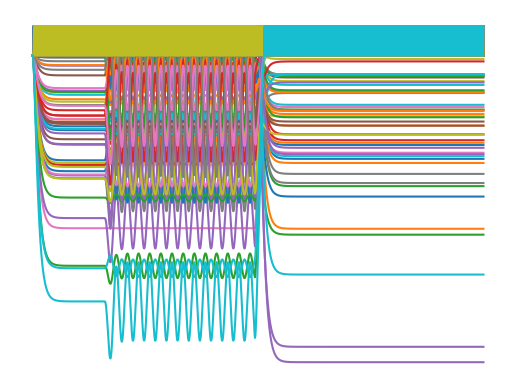

In [14]:
fig=plt.figure(dpi=100)
mem_rec, spk_rec = other_recs
plot_voltage_traces(mem_rec, spk_rec)

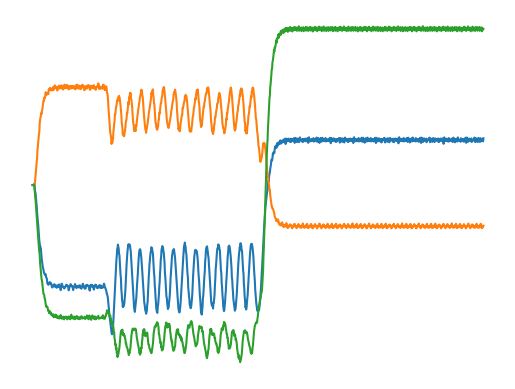

In [15]:
fig=plt.figure(dpi=100)        
plot_voltage_traces(out_rec)

In [18]:
params = [w1, w2, v]  # Parameters to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))  # Optimizer

loss_fn = nn.MSELoss()  # Mean squared error for regression

loss_hist = []

for e in range(5):
    print(e)
    # Run the network and get output
    o, _ = run_snn(inputs)  # output: (batch_size, timesteps, nb_outputs)
    
    # Compute the loss (compare output to desired outputs)
    # If outputs is (batch_size, timesteps, nb_outputs), use as is
    loss_val = loss_fn(o, outputs)
    
    # Update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    # Store loss value
    loss_hist.append(loss_val.item())

loss_hist_true_grad = loss_hist  # Store for later use

0
1
2
3
4


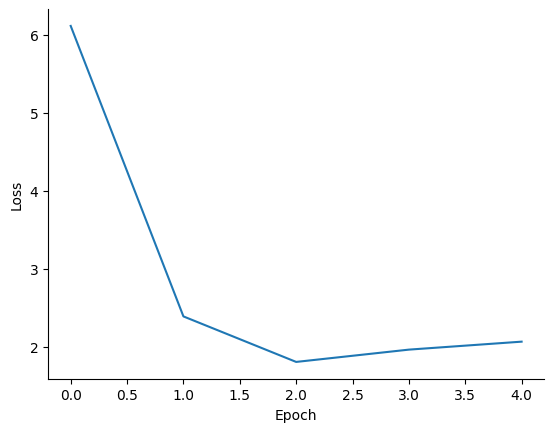

In [19]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [17]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

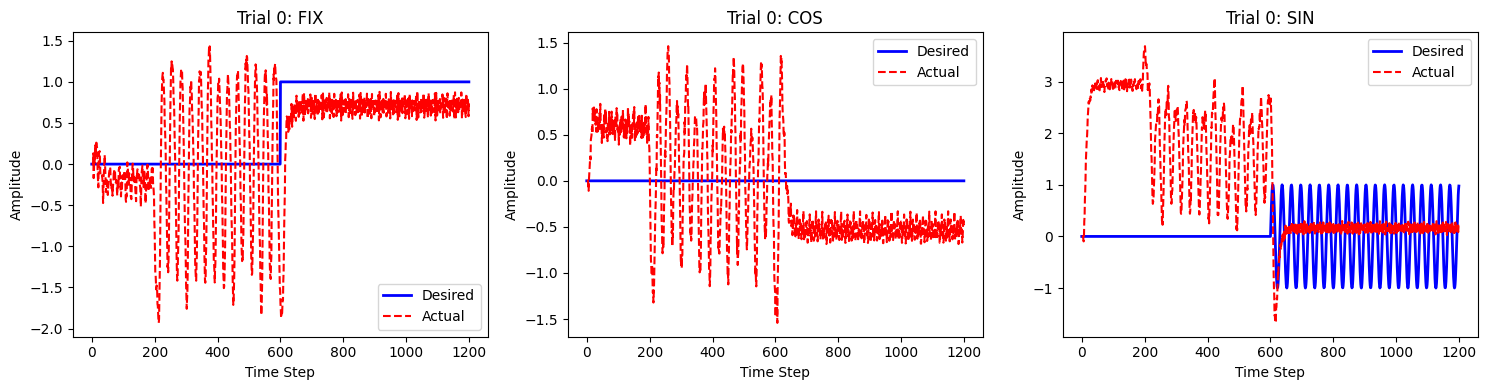

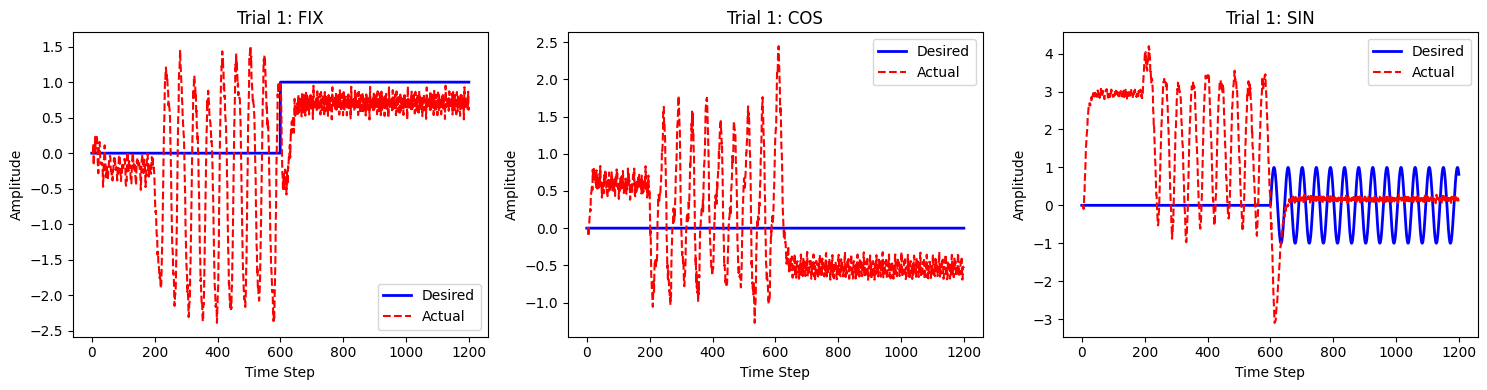

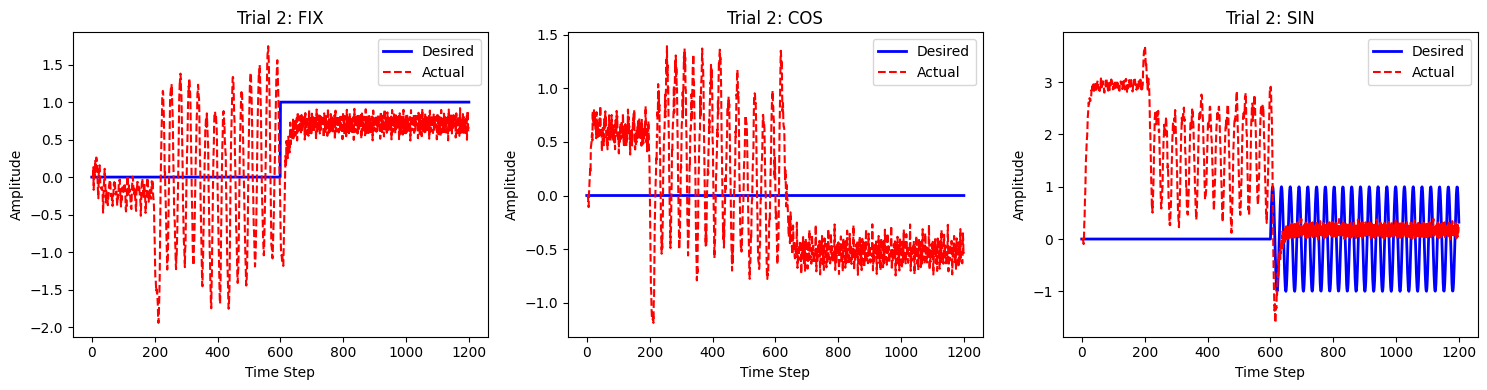

In [24]:
# Run the trained model on the test data (or reuse training data for demonstration)
test_output, _ = run_snn(inputs)  # Shape: (batch_size, timesteps, nb_outputs)

# Select a few example trials to plot
example_trials = [0, 1, 2]  # You can change these indices

def plot_trial_outputs(outputs, test_output, trial_idx, channel_names=None):
    """
    Plots desired vs actual outputs for all output channels for a given trial.
    """
    num_channels = outputs.shape[2]
    if channel_names is None:
        channel_names = [f'Channel {i}' for i in range(num_channels)]
    plt.figure(figsize=(5 * num_channels, 4))
    for ch in range(num_channels):
        plt.subplot(1, num_channels, ch + 1)
        plt.plot(outputs[trial_idx, :, ch].cpu().numpy(), label='Desired', color='blue', linewidth=2)
        plt.plot(test_output[trial_idx, :, ch].detach().cpu().numpy(), label='Actual', color='red', linestyle='--')
        plt.title(f'Trial {trial_idx}: {channel_names[ch]}')
        plt.xlabel('Time Step')
        plt.ylabel('Amplitude')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
example_trials = [0, 1, 2]
channel_names = ['FIX', 'COS', 'SIN']  # Adjust if your output channels differ
for trial in example_trials:
    plot_trial_outputs(outputs, test_output, trial, channel_names)